## 02 - Identificando os grupos etários com K-means: Kaggle Titanic

Exemplo de alternativa para identificação de grupos etários. O objetivo desse notebook é mostrar que o Machine Learning pode ser utilizado também no processo de limpeza de dados. É importante, porém, ter as etapas de limpeza e tratamento dos dados bem documentadas e passíveis de serem desfeitas, pois algoritmos diferentes podem performar melhor com diferentes estratégias de tratamento.

Este modelo serve mais como exemplo. Para a quantidade de dados no dataset e a facilidade de interpretação dos dados de idade isso poderia facilmente ser realizado manualmente ou com um código mais simples. O propósito aqui é exemplificar um uso.

## Preparando o ambiente

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

In [2]:
mpl.rcParams['figure.figsize'] = (12, 7)
sns.set(style='darkgrid')

## Carregando os dados

In [4]:
titanic = pd.read_csv('../data/processed/train_processed.csv')
del titanic['Unnamed: 0']
titanic.head(5)

,Survived,Pclass,Sex,Age,SibSp,Parch,Floor,Embarked,Relateds
0,0,3,male,22,1,0,SC,S,1
1,1,1,female,38,1,0,C,C,1
2,1,3,female,26,0,0,SC,S,0
3,1,1,female,35,1,0,C,S,1
4,0,3,male,35,0,0,SC,S,0


In [5]:
idades, frequencia = np.unique(titanic.Age.values, return_counts=True)

## Visualizando as idades e frequencias

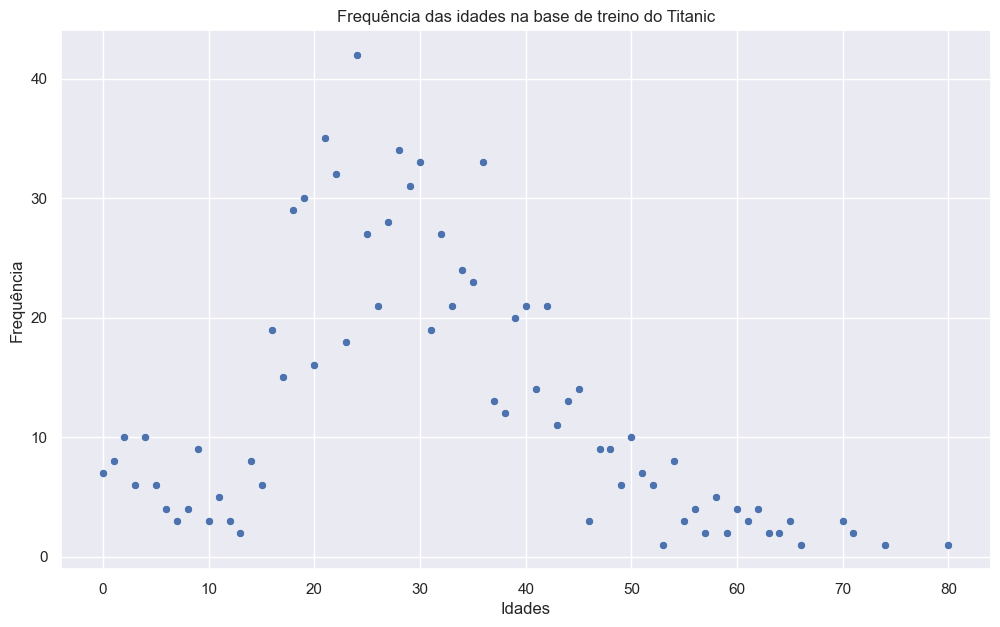

In [6]:
sns.scatterplot(x=idades, y=frequencia)
plt.xlabel('Idades')
plt.ylabel('Frequência')
plt.title('Frequência das idades na base de treino do Titanic')
plt.show();

## Criando os grupos

Utilizaremos um algoritmo de clusterização para separar as idades em grupos.

In [7]:
X = pd.DataFrame()
X['Idade'] = idades
X['Frequencia'] = frequencia
X

,Idade,Frequencia
0,0,7
1,1,8
2,2,10
3,3,6
4,4,10
...,...,...
66,66,1
67,70,3
68,71,2
69,74,1


Abaixo estamos realizando um "grid search" de forma explícita, ou seja, executando o mesmo algoritmo (`KMeans`) com diversas combinações de parâmetros e buscando o melhor. Para fins de exemplo, vários scores de análise de clusters estão sendo utilizados. Está além do escopo daqui explicar detalhadamente o funcionamento de cada um, mas o Scikit Learn possui as explicações matemáticas de cada um e a forma de interpretá-los.

In [18]:
n_clusters = [2, 3, 4, 5, 6, 7, 8, 9]
n_init = [10, 15, 20]
max_iter = [300, 500]
resultados = []
SEED = 42

for n in n_clusters:
    for i in n_init:
        for m in max_iter:
            agrupador = KMeans(n_clusters=n, n_init=i, max_iter=m, random_state=42)
            labels = agrupador.fit_predict(X)
            ss = silhouette_score(X, labels)
            ch = calinski_harabasz_score(X, labels)
            db = davies_bouldin_score(X, labels)
            values, counts = np.unique(labels, return_counts=True)
            r = {
                  'n_clusters': n,
                  'n_init': i,
                  'max_iter': m,
                  'Silhouette': ss,
                  'Calinski': ch,
                  'Bouldin':  db,
                  'counts': counts
            }
            resultados.append(r)

grupos = pd.DataFrame(data=resultados)

## Avaliando os modelos gerados

In [19]:
grupos.sort_values(by='Silhouette', ascending=False).head(5)

,n_clusters,n_init,max_iter,Silhouette,Calinski,Bouldin,counts
6,3,10,300,0.578952,175.572817,0.552968,"[18, 28, 25]"
7,3,10,500,0.578952,175.572817,0.552968,"[18, 28, 25]"
8,3,15,300,0.578952,175.572817,0.552968,"[18, 28, 25]"
9,3,15,500,0.578952,175.572817,0.552968,"[18, 28, 25]"
10,3,20,300,0.578952,175.572817,0.552968,"[18, 28, 25]"


O coeficiente de silhueta é bom para dados com curvas no espaço.

In [20]:
grupos.sort_values(by='Calinski', ascending=False).head(5)

,n_clusters,n_init,max_iter,Silhouette,Calinski,Bouldin,counts
47,9,20,500,0.443724,229.170679,0.639238,"[11, 10, 10, 6, 8, 6, 11, 4, 5]"
46,9,20,300,0.443724,229.170679,0.639238,"[11, 10, 10, 6, 8, 6, 11, 4, 5]"
45,9,15,500,0.443724,229.170679,0.639238,"[11, 10, 10, 6, 8, 6, 11, 4, 5]"
44,9,15,300,0.443724,229.170679,0.639238,"[11, 10, 10, 6, 8, 6, 11, 4, 5]"
43,9,10,500,0.426427,226.766484,0.685727,"[10, 11, 9, 9, 7, 4, 4, 6, 11]"


O Calinski não performa tão bem para dados com curva no espaço e com baixa densidade. Portanto não é a melhor métrica a ser usada para este dataset.

In [21]:
grupos.sort_values(by='Bouldin', ascending=True).head(5)

,n_clusters,n_init,max_iter,Silhouette,Calinski,Bouldin,counts
11,3,20,500,0.578952,175.572817,0.552968,"[18, 28, 25]"
6,3,10,300,0.578952,175.572817,0.552968,"[18, 28, 25]"
7,3,10,500,0.578952,175.572817,0.552968,"[18, 28, 25]"
8,3,15,300,0.578952,175.572817,0.552968,"[18, 28, 25]"
9,3,15,500,0.578952,175.572817,0.552968,"[18, 28, 25]"


O Bouldin é baseado na semelhança dos elementos dentro do cluster e diferença entre os clusters, sendo melhor mas semelhante ao coeficiente de silhueta. Abaixo o melhor modelo. Ele inclui 3 clusters.

In [22]:
grupos.sort_values(by=['Silhouette', 'Bouldin', 'Calinski', 'n_init', 'max_iter'], ascending=[False, True, True, True, True]).head(1)

,n_clusters,n_init,max_iter,Silhouette,Calinski,Bouldin,counts
6,3,10,300,0.578952,175.572817,0.552968,"[18, 28, 25]"


## Executando o modelo selecionado

O melhor modelo agrupou as idades em 3 pela frequência, permitindo, a princípio, uma categorização mais justa com relação à distribuição dos dados.

In [23]:
agrupador = KMeans(n_clusters=3, n_init=10, max_iter=300)
labels = agrupador.fit_predict(X)
X['cod_faixa_etaria'] = labels
X.sample(10)

,Idade,Frequencia,cod_faixa_etaria
24,24,42,1
53,53,1,0
60,60,4,0
44,44,13,0
7,7,3,2
48,48,9,0
37,37,13,1
0,0,7,2
58,58,5,0
11,11,5,2


In [24]:
X.groupby('cod_faixa_etaria').Idade.describe()

,count,mean,std,min,25%,50%,75%,max
cod_faixa_etaria,,,,,,,,
0,28.0,57.25,9.586352,43.0,49.75,56.5,63.25,80.0
1,25.0,30.00,7.359801,18.0,24.00,30.0,36.00,42.0
2,18.0,8.50,5.338539,0.0,4.25,8.5,12.75,17.0


**Faixas de idade identificadas:**

* _Criança/Adolescente_: 0 - 15
* _Jovem/Adulto_: 16 - 41
* _Adulto/Idoso_: 42 - 80

In [25]:
X.loc[(X['Idade'] == 16) | (X['Idade'] == 17), 'cod_faixa_etaria'] = 2
X.loc[(X['Idade'] == 16) | (X['Idade'] == 17)]

,Idade,Frequencia,cod_faixa_etaria
16,16,19,2
17,17,15,2


In [26]:
X.loc[(X['Idade'] == 42) | (X['Idade'] == 43), 'cod_faixa_etaria'] = 0
X.loc[(X['Idade'] == 42) | (X['Idade'] == 43)]

,Idade,Frequencia,cod_faixa_etaria
42,42,21,0
43,43,11,0


In [27]:
X.groupby('cod_faixa_etaria').Idade.describe()

,count,mean,std,min,25%,50%,75%,max
cod_faixa_etaria,,,,,,,,
0,29.0,56.724138,9.830334,42.0,49.00,56.0,63.00,80.0
1,24.0,29.500000,7.071068,18.0,23.75,29.5,35.25,41.0
2,18.0,8.500000,5.338539,0.0,4.25,8.5,12.75,17.0


In [28]:
map_idade = {
    0: 'adulto_idoso',
    1: 'crianca_adolescente',
    2: 'jovem_adulto'
}
titanic = (titanic.merge(X, left_on='Age', right_on='Idade')).drop(columns=['Idade', 'Frequencia'])
titanic['faixa_etaria'] = titanic.cod_faixa_etaria.map(map_idade)
titanic.sample(10)

,Survived,Pclass,Sex,Age,SibSp,Parch,Floor,Embarked,Relateds,cod_faixa_etaria,faixa_etaria
737,1,1,male,35,0,0,B,C,0,1,crianca_adolescente
619,0,2,male,26,0,0,SC,S,0,1,crianca_adolescente
107,1,3,male,39,0,0,SC,S,0,1,crianca_adolescente
540,1,1,female,36,0,2,B,S,2,1,crianca_adolescente
128,1,3,female,17,1,1,F,C,2,2,jovem_adulto
548,0,3,male,33,1,1,SC,S,2,1,crianca_adolescente
322,1,2,female,30,0,0,SC,Q,0,1,crianca_adolescente
727,1,3,female,12,0,0,SC,Q,0,2,jovem_adulto
369,1,1,female,24,0,0,B,C,0,1,crianca_adolescente
760,0,3,male,26,0,0,SC,S,0,1,crianca_adolescente


## Visualizando os agrupamentos

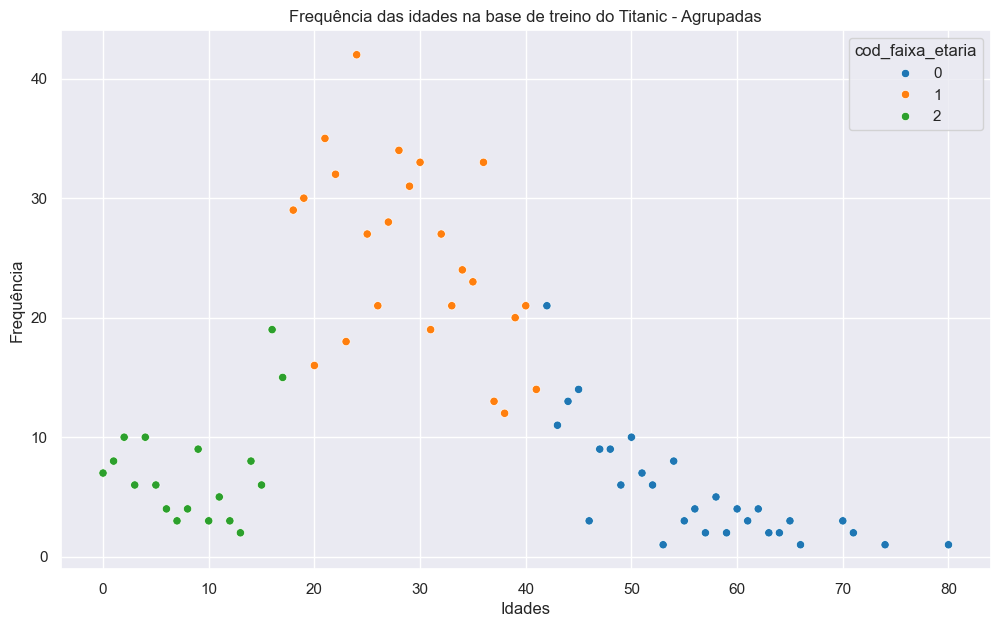

In [29]:
sns.scatterplot(x='Idade', y='Frequencia', data=X, hue='cod_faixa_etaria', palette="tab10")
plt.xlabel('Idades')
plt.ylabel('Frequência')
plt.title('Frequência das idades na base de treino do Titanic - Agrupadas')
plt.show();

In [22]:
del titanic['cod_faixa_etaria']

In [32]:
titanic.to_csv('../data/processed/train_processed_byage.csv')